# Traffic Flow with PDEs

#### <font color='gray'>Authors: Rob Hesselink(rob.hesselink@ens.fr) and Moshir Harsh (moshir.harsh@ens.fr)</font>

In this project model a traffic flow on a one dimensional road with periodic boundary conditions which is essentially a circular road.

We use the following equation called the WLR Equation:

\begin{equation}
 \frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}\left( v_0 \left(1-\frac{\rho}{\rho_0}\right)\rho \right) = 0 
\end{equation}

where $v_0$ and $\rho_0$ are the parameters which are set to one without loss of generality. So the equation becomes:

$$ \frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}\left(\left(1-\rho\right)\rho \right) = 0 $$

This equation can also be written as:

$$ \frac{\partial \rho}{\partial t} + \left(1-2\rho\right)\frac{\partial \rho}{\partial x} = 0 $$

This equation is known to form shocks (traffic jams) and is like the Burger's equation with the velocity which depends on density instead of being constant.

We simulate the solution to this equation using different schemes and compare our results. We also discuss the dispersive and/or the disspipative nature of these schemes.

In [13]:
# UNIVERSAL (ALWAYS RUN FIRST)

#Importing Packages
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
#matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

#Parameters:
N = 100.
dx = 1/N
dt = 1/(N)
T = 1.
v0 = 1
rho0 = 1
L_factor = 100



#Initial Conditions: Here we define various initial conditions, only uncomment the one to be used.

x0 = np.arange(0, 1, dx)
xL0 = np.arange(0,1, dx/L_factor)

#Sin Wave
p0 =  0.2 + 0.1*np.sin(np.arange(0, 2*np.pi, 2*np.pi*dx))
pL = 0.2 + 0.1*np.sin(np.arange(0, 2*np.pi, 2*np.pi*dx/L_factor))

#Block
#p0 = 0.2*np.ones(int(N))
#p0[20:30] = 0.4
#pL = 0.2*np.ones(int(N)*L_factor)
#pL[20*L_factor:30*L_factor] = 0.4

class variable():
    def __init__(self, value):        
        self.backup = np.copy(value)
        self.v = np.copy(value)
    
    def update(self, function):
        self.v = function(self.v)
        return self.v

    def reset(self):
        self.v = np.copy(self.backup)

p = variable(p0)
xL = variable(xL0)

def reset(variables = [p,xL]):
    for variable in variables:
        variable.reset()
    return 0

# Helper functions
def flux(shift, p):    
    """ Helper function for conservative schemes. """
    if shift == 0:
        return v0*(1 - p/rho0)*p
    else:
        return v0*(1 - np.roll(p, -shift)/rho0)*np.roll(p, -shift)

def velocity(shift = 0, array=p):
    """ Helper function for Godunov scheme. """
    if shift == 0:
        return v0*(1 - array/rho0)
    else:
        return v0*(1 - np.roll(array, -shift)/rho0)
    

    
def animate(i, scheme, line, mass, time):
    if scheme.str == "Lagrange":
        xL.update(scheme)
        line.set_data(xL.v, pL)
    else:
        p.update(scheme)
        line.set_data(x0, p.v)
                      
    time.set_text("T = " + "%.2f" % (i*dt)) 
    mass.set_text("M = " + "%.2f" % (np.sum(p.v)))
    return line, time, mass
    
def run(scheme):
    """ Helper function to animate different schemes. """    
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.set_xlim((0, 1))
    ax.set_ylim((0, .5))
    line, = ax.plot([], [], lw=2)
    ax.set_ylabel(r'$\rho$')
    ax.set_xlabel("x")
    time = ax.annotate("", xy=(.75, .45))
    mass = ax.annotate("", xy=(.75, .42))
    
    if scheme.str == "Lagrange":
        line.set_linestyle('none')
        line.set_marker('o')
        line.set_markersize(.06)
    
    ax.plot(x0, p0, "--")
    
    ax.set_title(scheme.str)
    anim = animation.FuncAnimation(fig, animate, fargs=(scheme, line, mass, time),
                               frames=int(T/dt), interval=50, blit=True)
    rc('animation', html='html5')
    plt.close(anim._fig)
    reset()
    return HTML(anim.to_html5_video())


    

## Finite Element Methods

### Lax-Friedrichs Finite Element Scheme

\begin{equation}
    u_x^{t+1} = \frac{u_{x+1}^t + u_{x-1}^t}{2} - (1 - 2u)\frac{\Delta t}{2 \Delta x}(u_{x+1}^t - u_{x-1}^t)
\end{equation}

In [14]:
def LF(p):
    """ Finite elements Lax-Friedrichs scheme. """  
    A = (np.roll(p, -1) + np.roll(p, 1))/2.
    B = -dt*(1 - 2*p)*(np.roll(p, -1) - np.roll(p, 1))/(2*dx)
    return (A + B)

LF.str = "Lax-Friedrichs"
run(LF)


##### Explanation:

The Lax-Friedrichs scheme is created through a small alteration to the $\delta_0$ scheme. By replacing $u_x^t$ with the average of the two neighbouring cells, the instability can be avoided and the scheme becomes conditionally stable. The Lax-Friedrichs scheme for the WLR equation is:
\begin{equation}
    u_x^{t+1} = \frac{u_{x+1}^t + u_{x-1}^t}{2} - (1 - 2u)\frac{\Delta t}{2 \Delta x}(u_{x+1}^t - u_{x-1}^t)
\end{equation}

The condition for stability can be determined by the Von Neumann analysis below. 
\begin{align}
    \xi &= \frac{e^{ik\Delta x} + e^{-ik\Delta x}}{2} - (1 - 2u)\frac{\Delta t}{2 \Delta x} \left(e^{ik\Delta x} - e^{ik\Delta x}\right) \\
    &= \cos{k\Delta x} - \frac{\Delta t}{\Delta x}(1 - 2u) i \sin{k \Delta x}.
 \end{align}
 To find our stability condition, we need to find the amplification factor
 \begin{align}
     |\xi|^2 &= \cos^2{k\Delta x} + r^2 \sin^2{k\Delta x} \\ 
             &= 1 - (1 - r^2)\sin^2{k\Delta x},
 \end{align}
 where $r \equiv \frac{\Delta t}{\Delta x}(1 - 2u) $. This shows that the scheme is stable as long as $r \leq 1$. The newfound stability comes at a cost, as the Lax-Friedrichs scheme introduces second-order numerical dissipation to the equation. The average of neighbours on the RHS can be expanded as
 
 \begin{align}
     \frac{u_{x+1}^t + u_{x-1}^t}{2} &= u_x^t + \frac{\Delta x^2}{2}\frac{\partial^2 u}{\partial x^2} + \mathcal{O}(x^4),
 \end{align}
and the numerical dissipation is identified as the second order derivative. 


### Lax-Wendroff Finite Elements Scheme

 \begin{align}
    u_x^{t+1} = u_x^t - \frac{\Delta t}{2 \Delta x}(u_{x+1}^t - u_{x-1}^t) + (1-2u)^2\frac{\Delta t^2}{2 \Delta x^2} (u_{x+1}^t - 2u_x^t + u_{x-1}^t). 
 \end{align}

In [15]:
def LW(p):
    """ Finite elements Lax-Wendroff scheme. """
    A = -(1 - 2*p)*(np.roll(p, -1) - np.roll(p, 1))/(2*dx)
    B = dt/2*(1 - 2*p)**2*(np.roll(p, -1) - 2*p + np.roll(p, 1))/(dx*dx)
    p += dt*(A + B)
    return p

LW.str = "Lax-Wendroff"
run(LW)


##### Explanation:
The Lax-Wendroff scheme is created by compensating explicitly for the dissipation in the $\delta_0$ scheme. If we look at the truncation of both sides of $\delta_0$, we can discover the dissipation term.

\begin{align}
    \frac{u_x^{t+1} - u_x^t}{\Delta t} &= \frac{\partial u}{\partial t} + \frac{\Delta t}{2}\frac{\partial^2 u}{\partial t^2} + \frac{\Delta t^2}{6} \frac{\partial^3 u}{\partial t^3} + \mathcal{O}(\Delta t^3)  \text{, and} \\
    \frac{u_{x+1}^t - u_{x-1}^t}{2\Delta x} &= \frac{\partial u}{\partial x} + \frac{\Delta x^2}{6}\frac{\partial^3 u}{\partial x^3} +  \mathcal{O}(\Delta x^3).
\end{align}
The dissipation term is first-order and can be rewritten by using the WLR equation to read:
\begin{align}
    \frac{\Delta t}{2}\frac{\partial^2 u}{\partial t^2} &= -(1-2u)^2\frac{\Delta t}{2}\frac{\partial^2 u}{\partial x^2} \\
    &= -(1-2u)^2\frac{\Delta t^2}{2 \Delta x^2} (u_{x+1}^t - 2u_x^t + u_{x-1}^t) + \mathcal{O}(\Delta x^2).
\end{align}
 
 By subtracting this term from the $\delta_0$ scheme, we are left with a dissipation-free second order scheme:
 \begin{align}
    u_x^{t+1} = u_x^t - \frac{\Delta t}{2 \Delta x}(u_{x+1}^t - u_{x-1}^t) + (1-2u)^2\frac{\Delta t^2}{2 \Delta x^2} (u_{x+1}^t - 2u_x^t + u_{x-1}^t). 
 \end{align}
 But alas, this scheme is still not perfect. As evidenced by the earlier identities for the truncation error, the leading-order truncation is now a dispersive term. 

##### Modified Wavenumber:
Another way to analyse the dispersive term is by looking at the modified wavenumber. Due to the discrete nature of the grid, waves consisting of high wavenumber $k$ (and therefore short wavelength) will be poorly sampled. This introduces a modified wavenumber $k'$. The expression for the modified wavenumber can be found by treating a Fourier mode $f = e^{ikx}$ with the scheme in question. For the Lax-Wendroff scheme 


\begin{equation}
    (1-2u)\frac{\partial \rho}{\partial x} \approx (1-2u)\frac{1}{2 \Delta x} (u_{x+1}^t - u_{x-1}^t) - (1-2u)^2\frac{\Delta t}{2 \Delta x^2} (u_{x+1}^t - 2u_x^t + u_{x-1}^t),
\end{equation}

this results in:
\begin{align}
    ik'f &=  \frac{1}{2 \Delta x}\left( e^{ik(x + \Delta x)} - e^{ik(x - \Delta x)}\right) - (1-2u)\frac{\Delta t}{2 \Delta x^2}\left(e^{ik(x + \Delta x)} -2e^{ikx} + e^{ik(x - \Delta x)}\right) \\
    ik' & = i\frac{\sin(k\Delta x)}{\Delta x} - (1-2u)\Delta t\frac{\cos(k\Delta x) - 2}{2 \Delta x} \\
    \frac{k'}{k}    &= \text{sinc}(k\Delta x) + 8i(1-2u)\text{sinc}^2\left(\frac{k\Delta x}{2}\right).
\end{align}

Compared to the modified wavenumber for the Lax-Friedrichs scheme, which gives





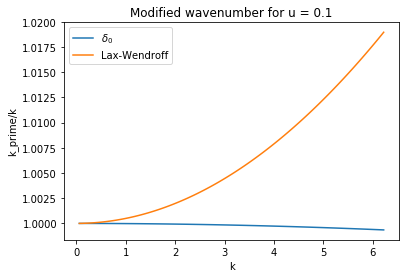

In [47]:
def k_d0(k):
    return np.sin(k*dx)/(k*dx)

def k_LW(k):
    return np.abs(k_d0(k) + 8j*(1-2*u)*np.sin(k*dx/2.)**2/(k*dx/2.))
u = .1

dk = 2*np.pi/N
k = np.arange(dk, 2*np.pi, dk)

plt.plot(k, k_d0(k), label=r'$\delta_0$')
plt.plot(k, k_LW(k), label="Lax-Wendroff")
plt.xlabel("k")
plt.ylabel("k_prime/k")
plt.title("Modified wavenumber for u = " + str(u))
plt.legend()
plt.show()

## Finite Volume Methods

Finite volumes scheme approach a problem by creating small cell within the domain and taking the average value of $u$ within that section. Changes in the system are then calculated by calculating the flux at the boundary of the cell. The advantage is that finite volumes schemes are inherently conservative. For the burger's equation, the flux can be identified in the continuity form of the WLR equation where, in discrete notation, $f_x^t = v_0 \left(1-\frac{\rho_x^t}{\rho_0}\right)\rho_x^t$. Both finite volume methods use 

\begin{align}
    u_x^{t+1} = u_x^t -\frac{\Delta t}{\Delta x}\left(f_{x+\frac{1}{2}}^{t+\frac{1}{2}} - f_{x-\frac{1}{2}}^{t+\frac{1}{2}}\right),
\end{align}

and the difference lies in correctly identifying the flux at the boundaries. 


### Lax-Freidrich Finite Volumes Scheme

\begin{align}
    u_x^{t+1} = \frac{u_{x+1}^t + u_{x-1}^t}{2} -\frac{\Delta t}{2\Delta x}\left(f_{x+1}^{t} - f_{x-1}^{t}\right).
\end{align}

In [48]:
def LF_cons(p):
    """ Lax-Friedrichs conservative scheme. """
    f_left = 0.5*(flux(-1, p) + flux(0, p)) - dt/(2*dx)*(p - np.roll(p, 1))
    f_right = 0.5*(flux(0, p) + flux(1, p)) - dt/(2*dx)*(np.roll(p, -1) - p)

    p += -dt/dx*(f_right - f_left)
    return p

LF_cons.str = "Lax-Friedrichs conservative"
run(LF_cons)


##### Explanation:
The finite volumes version of the Lax-Friedrichs scheme is similar to its finite differences cousin. It replaces the $u_x^t$ by the average of neighbours, but does so implicitly by defining the flux at the boundary as
\begin{align}
    f_{x+\frac{1}{2}}^{t+\frac{1}{2}} = \frac{1}{2}(f_{x+1}^t + f_x^t) - \frac{\Delta x}{2\Delta t}(u_{x+1}^t - u_x^t), 
\end{align}
which results in a final scheme of 
\begin{align}
    u_x^{t+1} = \frac{u_{x+1}^t + u_{x-1}^t}{2} -\frac{\Delta t}{2\Delta x}\left(f_{x+1}^{t} - f_{x-1}^{t}\right).
\end{align}
Its stability and introduction of dissipation are the same as the finite differences version, given a sufficiently smooth solution. 


### Lax-Wendroff Finite Volumes Scheme

\begin{align}
    u_{x+\frac{1}{2}}^{t+\frac{1}{2}} = \frac{u_{x+1} + u_{x-1}^t}{2} - \frac{\Delta t}{2\Delta x}(f_{x+1}^t - f_x^t)
\end{align}

In [49]:
def LW_cons(p):    
    """ Lax-Wendroff conservative scheme. """
    u_right = 0.5*(np.roll(p, -1) + p) - dt/(2*dx)*(flux(1, p) - flux(0, p))
    u_left  = 0.5*(p + np.roll(p, 1))  - dt/(2*dx)*(flux(0, p) - flux(-1, p))

    f_right = v0*(1 - u_right/rho0)*u_right
    f_left = v0*(1 - u_left/rho0)*u_left
    
    p += -dt/dx*(f_right - f_left)
    return p

LW_cons.str = "Lax-Wendroff conservative"
run(LW_cons)


##### Explanation:
This scheme again compensates for the dissipation of the simple centered scheme. By defining

\begin{align}
    u_{x+\frac{1}{2}}^{t+\frac{1}{2}} = \frac{u_{x+1} + u_{x-1}^t}{2} - \frac{\Delta t}{2\Delta x}(f_{x+1}^t - f_x^t), 
\end{align}
the added flux term on the right corresponds to the second derivative as seen in the finite differences version. 

## Gudonov Method

In [50]:
def Godunov(p):
    """ Godunov scheme """
    vl = velocity(0, p)
    vr = velocity(1, p)
    ul = p
    ur = np.roll(p, -1)

    #Shock or rarefaction?
    Shock = vl - vr > 0 # 1 is shock, 0 = rarefaction.
    Rare = Shock != 1

    #Direction of shock. 
    Sl = (vl + vr)/2. < 0
    Sr = Sl != 1

    #Sign of velocity.
    v_right = (vl >= 0) == (vr > 0)
    v_centre = (vl < 0) == (vr > 0) #Not necessary?
    v_left = (vr <= 0) == (vl > 0)
    
    # Adding shock.
    u  = Shock*Sl*ur   
    u += Shock*Sr*ul

    #Adding rarefaction.
    u += Rare*v_right*ul
    u += Rare*v_left*ur

    f_right = velocity(0, u)*u
    f_left  = velocity(-1, u)*np.roll(u, 1)

    p += -dt/dx*(f_right - f_left)
    return p

Godunov.str = "Godunov Method"
run(Godunov)


##### Explanation:
The Godunov method follows the earlier conservative schemes by using 
\begin{align}
    u_x^{t+1} = u_x^t -\frac{\Delta t}{\Delta x}\left(f_{x+\frac{1}{2}}^{t+\frac{1}{2}} - f_{x-\frac{1}{2}}^{t+\frac{1}{2}}\right)
\end{align}
to update its values in time and is therefore also conservative. Again, the trouble is finding the value of the flux at the border of the cell $f_{x+\frac{1}{2}}^{t+\frac{1}{2}}$. 

The Godunov method views the boundaries between adjacent cells as Riemann problems. Our discrete grid gives us a piecewise constant function, with discontinuities at the boundaries, which can be stated as follows:

\begin{equation}
    u(x, 0)=
    \begin{cases}
      u_l, & \text{if}\ x<0 \\
      u_r, & \text{if}\ x>0
    \end{cases}
 \end{equation}
 
 By solving the above Riemann problem, the halfway value $u(0)$ can be found. The derivation of the Godunov scheme is a bit too broad for the scope of this work, but can be found in ADD REFERENCE!!!!!. Concretely, solving the Riemann problem comes down to the case of shock ($u_l > u_r$) and rarefaction ($u_l \leq u_r$). In case of shock:

\begin{align}
    \text{Shock speed } S \equiv \frac{u_l + u_r}{2}\\
    u(0)=
    \begin{cases}
      u_l, & \text{if}\ S > 0 \\
      u_r, & \text{if}\ S < 0
    \end{cases}
 \end{align}

In case of rarefaction:
\begin{align}
    u(0)=
    \begin{cases}
      u_l, & \text{if}\ 0 \leq u_l \\
      0,   & \text{if}\ u_l < 0 < u_r \\
      u_r, & \text{if}\ u_r \leq 0
    \end{cases}
 \end{align}




## An Exact Numerical Solution by the Lagrange Method 

In [51]:
def Lagrange(X, p0 = pL):
    """ Lagrangian solution. Returns x, not p!"""
    X = np.mod(X + (1-2*p0)*dt, 1)
    return X

Lagrange.str = "Lagrange"
run(Lagrange)
    

##### Explanation:

This method uses the total derivative of each point (points being sampled from the initial conditions) to calculate how much each point moves in space per unit time.

In dt time, each point moves a distance = vdt where velocity for WLR equation = $1-2\rho$. This perfectly works up until the shock point an dit exact but after the schock it becomes unphysical.


# Comparison
The following function plots all the previous functions side by side.

In [52]:
schemes = [LF, LW, LF_cons, LW_cons, Godunov, Lagrange]

p_dict = {}
lines_dict = {}


def animate_all(i, schemes):
    for scheme in schemes:
        p_dict[scheme].update(scheme)
        if scheme.str == "Lagrange":
            lines_dict[scheme].set_data(p_dict[scheme].v, pL)
        else:
            lines_dict[scheme].set_data(x0, p_dict[scheme].v)
            
    return lines_dict.values()
    
def run_all(schemes=schemes):
    """ Helper function to animate different schemes. """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Comparison of schemes")
    ax.set_xlim((0, 1))
    ax.set_ylim((0, .5))
    ax.set_ylabel(r'$\rho$')
    ax.set_xlabel("x")
    
    for scheme in schemes:
        if scheme.str == "Lagrange":
            p_dict[scheme] = variable(xL0)
            lines_dict[scheme] = ax.plot([], [], 'bo', markersize=.01, label=scheme.str)[0]
        else:
            p_dict[scheme] = variable(p0)
            lines_dict[scheme] = ax.plot([], [], label=scheme.str)[0]

    ax.plot(x0, p0, "--")
    anim = animation.FuncAnimation(fig, animate_all, fargs=(schemes,),
                               frames=int(T/dt), interval=50, blit=True)
    plt.legend()

    rc('animation', html='html5')
    plt.close(anim._fig)
    reset()
    return HTML(anim.to_html5_video())
    
run_all()

##### Comment:
As can be seen from the above animation, the Lax-Wendroff scheme quickly falls behind the other schemes. This is explained by  its increase in mass, seen previously. Since the speed of the wave is dependent on $(1-2u)$, as soon as total mass $m =  \sum_{n=0}^N u$ increases, overall speed decreases. The phenomenon is not observed in its conservative cousin.

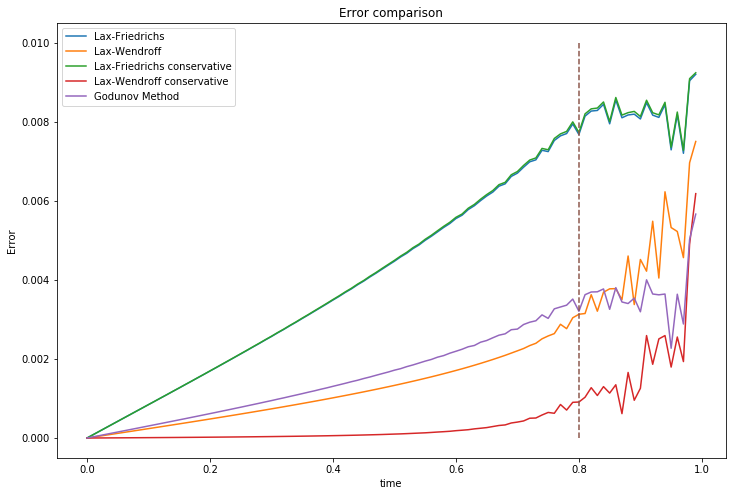

In [53]:
schemes = [LF, LW, LF_cons, LW_cons, Godunov]

p_dict = {}
p_dict[Lagrange] = variable(xL0)
diff_dict = {}
time = np.arange(0, T, dt)

def L2(a, b):
    """returns the L2 norm of the system"""
    return np.sum(np.sqrt((b - a)**2))/N

def check_collapse(x):
    count = np.sum(x - np.roll(x, 1) < 0)
    if count >1:
        return True
    return False
    
    

def compare():
    plt.figure(figsize=(12, 8))
    plt.xlabel("time")
    plt.ylabel("Error")
    plt.title("Error comparison")
    
    t_collapse = 0

    for scheme in schemes:
        p_dict[scheme] = variable(p0)
        diff_dict[scheme] = []
    
    
    for t in np.arange(0, T, dt):
        if check_collapse(p_dict[Lagrange].v) and t_collapse == 0:
            t_collapse = t
            
        for scheme in schemes:
            diff_dict[scheme].append(L2(np.interp(x0, p_dict[Lagrange].v, pL, period=1), p_dict[scheme].v))
        
        
            p_dict[scheme].update(scheme)
        p_dict[Lagrange].update(Lagrange)
    
            
    for scheme in schemes:
        plt.plot(time, diff_dict[scheme], label=scheme.str)
    if t_collapse != 0:
        plt.plot([t_collapse, t_collapse], [0,.01], "--")
    plt.legend()
    plt.show()
    reset()


compare()